In [1]:
# autoreload magic
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
import scipy
from scipy import stats


from utils.analysis_utils import (
    load_qa,
    load_debate, 
    load_verdict,
    load_debate_and_verdict,
    load_debate_and_verdict_and_qa,
    sort_and_color_by_model_family
)

from views.view_runs import get_verdict_configs
from typing import Literal


### Analyze QA accuracy

In [2]:
filters = {
    # MODEL OPTIONS
    # 'config_model_name': "x-ai/grok-4-fast",
    'config_model_name': "openai/gpt-4o-mini",
    # 'config_model_name': "qwen/qwen-2.5-7b-instruct",
    # 'config_model_name': "meta-llama/llama-3-8b-instruct",

    # DATASET OPTIONS
    'config_dataset_name': "Idavidrein/gpqa",
    'config_dataset_subset': "gpqa_diamond",
    'config_dataset_split': "train",

    # 'config_dataset_name': "TIGER-Lab/MMLU-Pro",
    # 'config_dataset_subset': None,
    # 'config_dataset_split': "test",

    # OTHER OPTIONS
    'config_random_seed': 42,
    'config_num_choices': 2,
}


In [3]:
df = load_qa(filters)

accuracy = df['is_correct'].mean()
correct_count = df['is_correct'].sum()
total_count = len(df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 62.63%
Correct: 124/198


### Analyze verdict accuracy

In [4]:
run_id = 'hdudzt0'

df = load_verdict(run_id)

accuracy = df['is_correct_verdict'].mean()
correct_count = df['is_correct_verdict'].sum()
total_count = len(df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 64.80%
Correct: 127/196


### Compared Verdict to QA accuracy

In [5]:
# verdict_run_id = 'uh2gayc'
verdict_run_id = 'k26y5y6'

merged_df = load_debate_and_verdict_and_qa(verdict_run_id)

judge_qa = merged_df["is_correct_judge_qa"].mean().round(2) 
debater_qa = merged_df["is_correct_debater_qa"].mean().round(2)
debate_verdict = merged_df["is_correct_verdict"].mean().round(2)

print()
print(f'Judge QA: {judge_qa} ({merged_df["is_correct_judge_qa"].sum()}/{merged_df["is_correct_judge_qa"].count()})')
print(f'Debater QA: {debater_qa} ({merged_df["is_correct_debater_qa"].sum()}/{merged_df["is_correct_debater_qa"].count()})')
print(f'Debate Verdict: {debate_verdict} ({merged_df["is_correct_verdict"].sum()}/{merged_df["is_correct_verdict"].count()})')

loaded verdict: k26y5y6: starting records: 193, dropped 0 without judge QA, dropped 0 without debater QA, final records: 193

Judge QA: 0.63 (121/193)
Debater QA: 0.94 (181/193)
Debate Verdict: 0.74 (143/193)


In [6]:
# Display columns that start with 'config'
pd.set_option('display.max_columns', None)
config_columns = [col for col in merged_df.columns if col.startswith('config')]
merged_df[config_columns].head()

,config,config_debate_dataset_name,config_debate_dataset_subset,config_debate_dataset_split,config_debate_debater_model,config_debate_debater_temperature,config_debate_max_output_tokens,config_debate_debater_reasoning_effort,config_debate_debater_reasoning_max_tokens,config_debate_num_questions,config_debate_random_seed,config_debate_num_choices,config_debate_num_turns,config_debate_private_scratchpad,config_debate_public_argument_word_limit,config_debate_private_reasoning_word_limit,config_debate_max_threads,config_verdict_debate_run_id,config_verdict_judge_model,config_verdict_judge_temperature,config_verdict_max_output_tokens,config_verdict_judge_reasoning_effort,config_verdict_judge_reasoning_max_tokens,config_model_name_x,config_model_name_y
0,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,None,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
1,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,None,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
2,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,None,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
3,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,None,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
4,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,None,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast


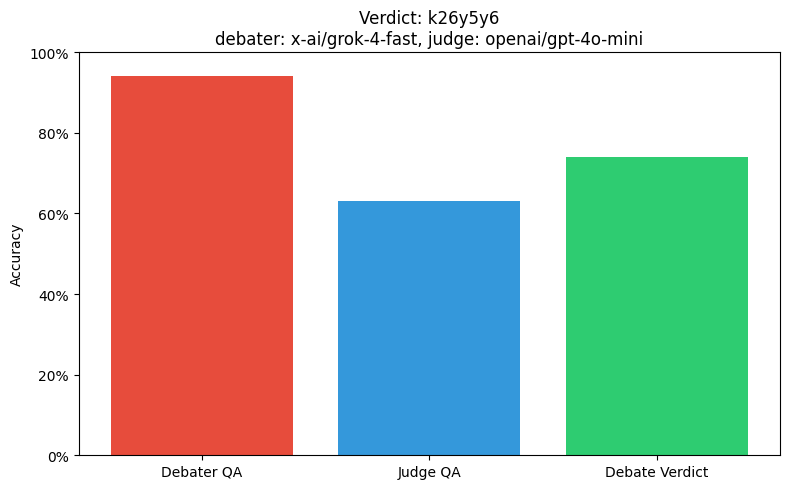

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Debater QA', 'Judge QA', 'Debate Verdict'], [debater_qa, judge_qa, debate_verdict], color=['#e74c3c', '#3498db', '#2ecc71'])                                                                                   
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
debater_model = merged_df['config_debate_debater_model'].iloc[0]
judge_model = merged_df['config_verdict_judge_model'].iloc[0]
plt.title(f'Verdict: {verdict_run_id}\ndebater: {debater_model}, judge: {judge_model}')
plt.tight_layout()
plt.show()

### Compare accuracies across verdicts (by default, combine runs that have the same config)

In [ ]:
from utils.analysis_utils import load_debate_and_verdict_and_qa, load_unique_over_runs

def results_by_config(unique_df, dedupe_columns):
    print('hi')
    """
    Collapses across runs to get the unique records pertaining to each config (or, the config params that matter)
    """
    results = []
    # Get the unique records over runs
    dedupe_columns = [col for col in dedupe_columns if col != 'record_id']

    # Get the unique configs
    unique_configs = unique_df[dedupe_columns].drop_duplicates().to_dict('records')
    varying_cols = [col for col in dedupe_columns if unique_df[col].nunique() > 1]

    # Optionally, only keep records that are present for every verdict run
    # n_runs = len(unique_configs)
    # unique_df = unique_df.groupby('record_id').filter(lambda x: len(x) == n_runs)

    # Get the records and summary for each unique config
    for unique_config in unique_configs:
        filtered_df = unique_df.copy()
        for key, value in unique_config.items():
            if value is None or pd.isna(value):
                filtered_df = filtered_df[filtered_df[key].isna()]
            else:
                filtered_df = filtered_df[filtered_df[key] == value]

        # Name the column for the value of the varying columns
        name = ""
        for col in varying_cols:
            if col in unique_config:
                name += (f"{unique_config[col]},")
        name = name.strip(",")

        results.append({
            'name': name,
            'debater_qa_acc': filtered_df['is_correct_debater_qa'].mean(),
            'judge_qa_acc': filtered_df['is_correct_judge_qa'].mean(),
            'verdict_acc': filtered_df['is_correct_verdict'].mean(),
            'debater_qa_n_correct': filtered_df['is_correct_debater_qa'].sum(),
            'judge_qa_n_correct': filtered_df['is_correct_judge_qa'].sum(),
            'verdict_n_correct': filtered_df['is_correct_verdict'].sum(),
            'verdict_non_null': filtered_df['is_correct_verdict'].notnull().sum(),
            'judge_qa_non_null': filtered_df['is_correct_judge_qa'].notnull().sum(),
            'debater_qa_non_null': filtered_df['is_correct_debater_qa'].notnull().sum(),
            'n_total': len(filtered_df),
            'verdict_minus_judge_qa': filtered_df['is_correct_verdict'].mean() - filtered_df['is_correct_judge_qa'].mean(),
            'pgr': (filtered_df['is_correct_verdict'].mean() - filtered_df['is_correct_judge_qa'].mean()) / (filtered_df['is_correct_debater_qa'].mean() - filtered_df['is_correct_judge_qa'].mean()),
            'debater_minus_judge_qa': filtered_df['is_correct_debater_qa'].mean() - filtered_df['is_correct_judge_qa'].mean(),
        })

    results_df = pd.DataFrame(results)
    return results_df

def results_by_run(verdict_ids):
    results = []
    for vid in verdict_ids:
        df = load_debate_and_verdict_and_qa(vid)
        n = len(df)
        results.append({
            'name': vid,
            'debater_qa_acc': df['is_correct_debater_qa'].mean(),
            'judge_qa_acc': df['is_correct_judge_qa'].mean(),
            'verdict_acc': df['is_correct_verdict'].mean(),
            'debater_qa_n_correct': df['is_correct_debater_qa'].sum(),
            'judge_qa_n_correct': df['is_correct_judge_qa'].sum(),
            'verdict_n_correct': df['is_correct_verdict'].sum(),
            'n_total': n
        })
    results_df = pd.DataFrame(results)
    return results_df


In [22]:
# verdict_ids = ['k26y5y6', 'kn8lecm', 'hmsolpd', 'okcg9s1']
# verdict_ids = ['yt32eoi', 'ouuwuug', 'qiqr2wo', '0va6ifr']
# results_df = results_by_run(verdict_ids)

# look at gqpa 4 choice and 2 choice (unique over runs)
verdicts_df = get_verdict_configs()


verdict_ids_gpqa_2_choice =  ['o6nh196', 'se5tc1t', 'okcg9s1', 'px68tl7', 'gt5hbbc', 'omurjjz', '2ayhhpd', '7ir6j2d', 'mr8lipz', 'kn8lecm', 'k26y5y6', 'uopuf76', 'hmsolpd', 'wvubqq5', '0q341gz', 'm6zo8vx', 'jgrph0e']
# verdict_ids_gpqa_4_choice =  ['2bmbqk1', 'po3v9oq', 'qx50tbo', 'jm9kod3', '4rg7b4b', 'faqmo5o', 'dph0qre', '9jiz6cv', 'p8zeu0p', 'ouuwuug', 'yt32eoi', 'vwmy4y3', 'qiqr2wo', '2pvnm1z', 'ujzubt9', '4ukh5h7', '3oxc0v3']


# verdict_ids_gpqa_4_choice = verdicts_df[verdicts_df['debate_id'] == 'q6wpwb7']['verdict_id'].tolist()
# unique_df_gpqa_4_choice, dedupe_columns_gpqa_4_choice = load_unique_over_runs(verdict_ids_gpqa_4_choice, 'load_debate_and_verdict_and_qa')
# results_df_gpqa_4_choice = 
# (unique_df_gpqa_4_choice, dedupe_columns_gpqa_4_choice)

# verdict_ids_gpqa_2_choice = verdicts_df[verdicts_df['debate_id'] == '17zguxe']['verdict_id'].tolist()


# unique_df_gpqa_2_choice, dedupe_columns_gpqa_2_choice = load_unique_over_runs(verdict_ids_gpqa_2_choice, 'load_debate_and_verdict_and_qa')
results_df_gpqa_2_choice = results_by_config(unique_df_gpqa_2_choice, dedupe_columns_gpqa_2_choice)

results_df_gpqa_2_choice

In [18]:
results_df_gpqa_2_choice

,name,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,verdict_minus_judge_qa,pgr,debater_minus_judge_qa
0,google/gemma-3-12b-it,0.931429,0.588571,0.588571,163,103,103,175,0.000000,0.000000,0.342857
1,openai/gpt-4o-mini,0.921875,0.572917,0.739583,177,110,142,192,0.166667,0.477612,0.348958
2,qwen/qwen-2.5-72b-instruct,0.922280,0.637306,0.725389,178,123,140,193,0.088083,0.309091,0.284974
3,meta-llama/llama-4-scout,0.920000,0.697143,0.720000,161,122,126,175,0.022857,0.102564,0.222857
4,openai/gpt-3.5-turbo,0.920635,0.492063,0.444444,174,93,84,189,-0.047619,-0.111111,0.428571
5,qwen/qwen3-235b-a22b,0.896104,0.792208,0.844156,69,61,65,77,0.051948,0.500000,0.103896
6,qwen/qwen3-32b,0.924051,0.810127,0.873418,146,128,138,158,0.063291,0.555556,0.113924
7,qwen/qwen3-14b,0.936047,0.767442,0.831395,161,132,143,172,0.063953,0.379310,0.168605
8,qwen/qwen3-8b,0.918919,0.837838,0.864865,68,62,64,74,0.027027,0.333333,0.081081
9,qwen/qwen-2.5-7b-instruct,0.918033,0.502732,0.590164,168,92,108,183,0.087432,0.210526,0.415301


In [19]:
135/192

0.703125

debater_qa_acc: 0.92, judge_qa_acc: 0.65, verdict_acc: 0.67


NameError: name 'n_choices' is not defined

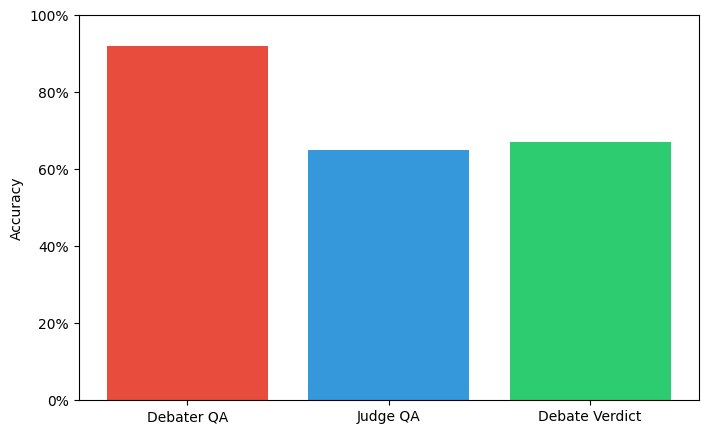

In [13]:
results_df = results_df_gpqa_2_choice
# results_df = results_df_gpqa_4_choice

total_records = results_df[f'n_total'].sum()
debater_qa = round(results_df[f'debater_qa_n_correct'].sum() /total_records, 2)
judge_qa = round(results_df[f'judge_qa_n_correct'].sum() /total_records, 2)
debate_verdict = round(results_df[f'verdict_n_correct'].sum() /total_records, 2)

print(f'debater_qa_acc: {debater_qa}, judge_qa_acc: {judge_qa}, verdict_acc: {debate_verdict}')

# Bar 
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Debater QA', 'Judge QA', 'Debate Verdict'], [debater_qa, judge_qa, debate_verdict], color=['#e74c3c', '#3498db', '#2ecc71'])                                                                                   
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.title(f'Aggregate Across Models For GPQA {n_choices} Choice (N={total_records})')
plt.tight_layout()
plt.show()

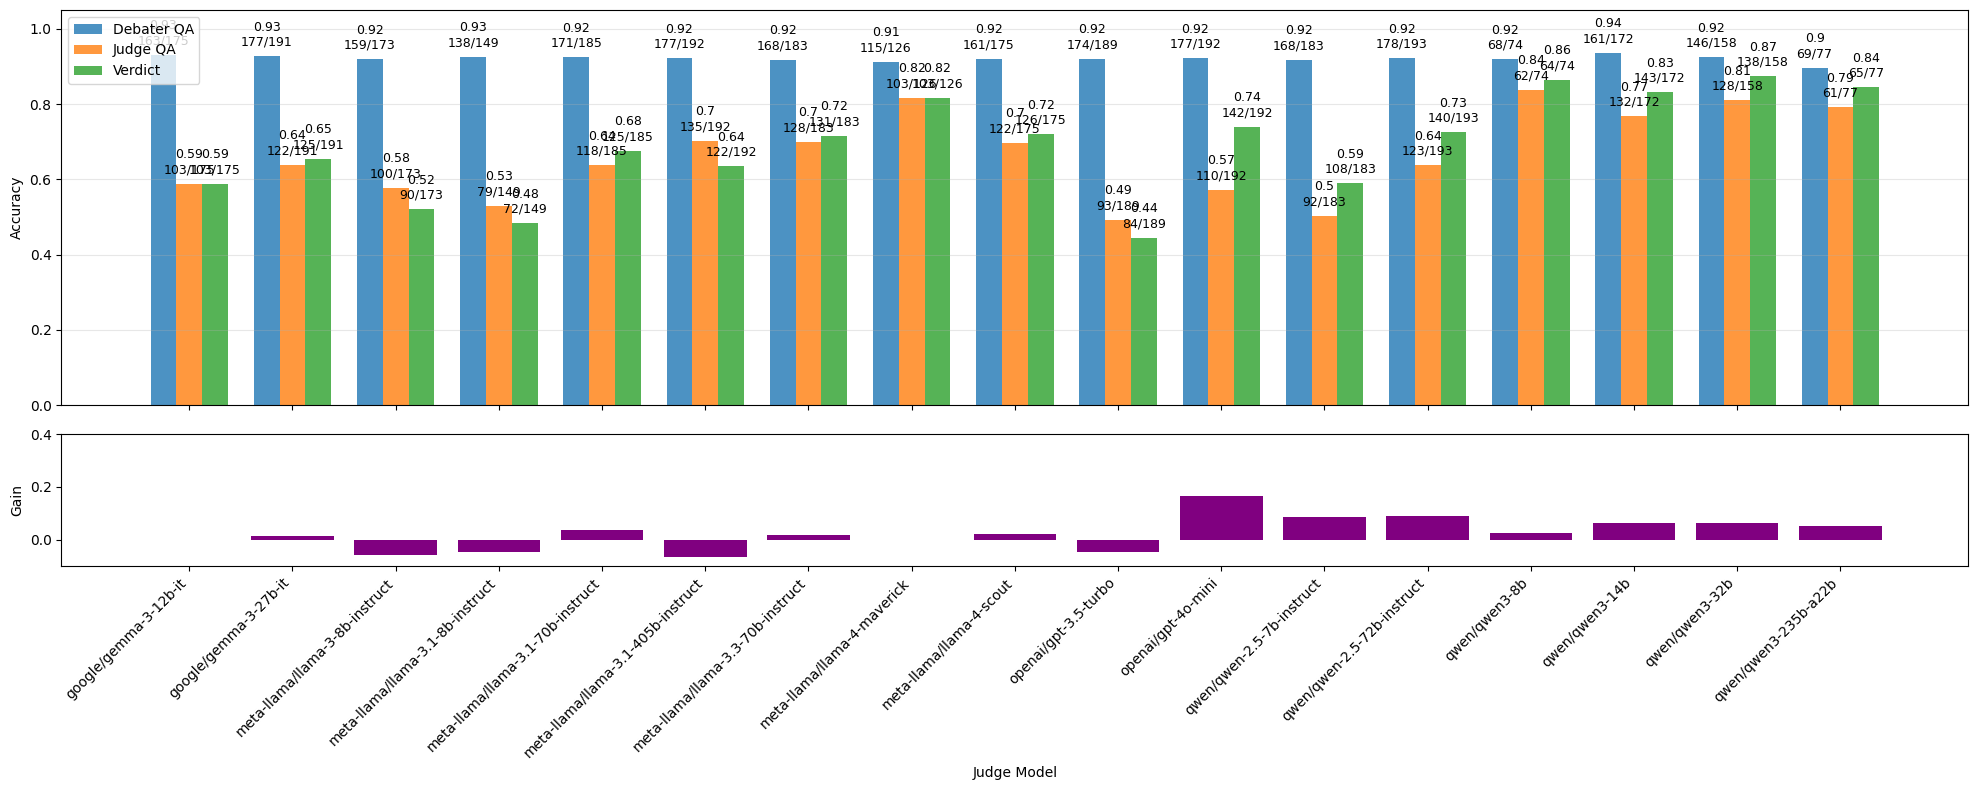

In [15]:
def _prep_results_df(results_df):
    results_df = results_df.copy()
    results_df['verdict_minus_judge_qa'] = results_df['verdict_acc'] - results_df['judge_qa_acc']
    names, _ = sort_and_color_by_model_family(results_df['name'].unique())
    return results_df.set_index('name').loc[names].reset_index()

def plot_accuracy_bars(results_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 6))
    
    results_df = _prep_results_df(results_df)
    x = np.arange(len(results_df))
    width = 0.25

    bars1 = ax.bar(x - width, results_df['debater_qa_acc'], width, label='Debater QA', alpha=0.8)
    bars2 = ax.bar(x, results_df['judge_qa_acc'], width, label='Judge QA', alpha=0.8)
    bars3 = ax.bar(x + width, results_df['verdict_acc'], width, label='Verdict', alpha=0.8)

    for i, (b1, b2, b3) in enumerate(zip(bars1, bars2, bars3)):
        ratio1 = round(results_df.iloc[i]['debater_qa_acc'], 2)
        ratio2 = round(results_df.iloc[i]['judge_qa_acc'], 2)
        ratio3 = round(results_df.iloc[i]['verdict_acc'], 2)
        
        ax.text(b1.get_x() + b1.get_width()/2, b1.get_height() + 0.02, 
                f"{ratio1}\n{results_df.iloc[i]['debater_qa_n_correct']:.0f}/{results_df.iloc[i]['n_total']}", 
                ha='center', va='bottom', fontsize=9)
        ax.text(b2.get_x() + b2.get_width()/2, b2.get_height() + 0.02, 
                f"{ratio2}\n{results_df.iloc[i]['judge_qa_n_correct']:.0f}/{results_df.iloc[i]['n_total']}", 
                ha='center', va='bottom', fontsize=9)
        ax.text(b3.get_x() + b3.get_width()/2, b3.get_height() + 0.02, 
                f"{ratio3}\n{results_df.iloc[i]['verdict_n_correct']:.0f}/{results_df.iloc[i]['n_total']}", 
                ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['name'], rotation=45, ha='right')
    return ax

def plot_verdict_difference(results_df, ax=None, type='gain'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 2))
    
    results_df = _prep_results_df(results_df)
    if type == 'gain':
        bars =ax.bar(results_df['name'], results_df['verdict_minus_judge_qa'], color='purple')
        ylabel = 'Gain'
    elif type == 'pgr':
        bars = ax.bar(results_df['name'], results_df['pgr'], color='purple')
        ylabel = 'PGR'
    elif type == 'gap':
        bars = ax.bar(results_df['name'], results_df['debater_minus_judge_qa'], color='purple')
        ylabel = 'Gap'
    ax.set_ylim(-.1, 0.4)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Judge Model')
    ax.set_xticklabels(results_df['name'], rotation=45, ha='right')
    return bars

def plot_results_by_name(results_df):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    plot_accuracy_bars(results_df, ax=ax[0])
    plot_verdict_difference(results_df, ax=ax[1])
    plt.tight_layout()
    plt.show()

results_df = results_df_gpqa_2_choice
# results_df = results_df_gpqa_4_choice

plot_results_by_name(results_df)

In [17]:
# 135/192
126/188

0.6702127659574468

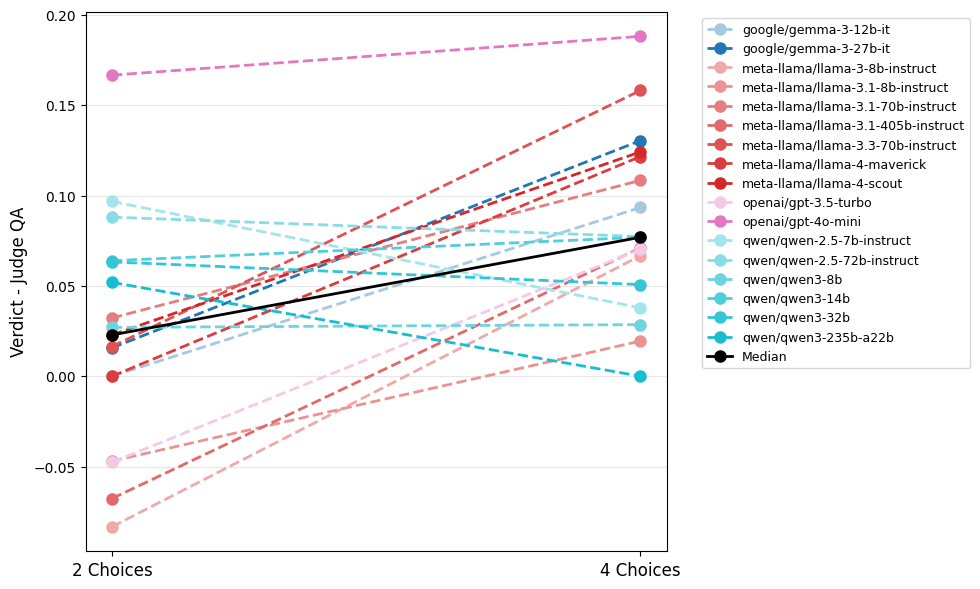

In [420]:
merged = results_df_gpqa_2_choice.merge(
    results_df_gpqa_4_choice, 
    on='name', 
    suffixes=('_2choice', '_4choice')
)

sorted_names, color_map = sort_and_color_by_model_family(merged['name'].unique())
merged['sort_order'] = merged['name'].map({name: i for i, name in enumerate(sorted_names)})
merged = merged.sort_values('sort_order').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

for _, row in merged.iterrows():
    ax.plot([0, 1], [row['verdict_minus_judge_qa_2choice'], row['verdict_minus_judge_qa_4choice']], 
            marker='o', label=row['name'], color=color_map[row['name']], linewidth=2, markersize=8, linestyle='--')

ax.plot([0, 1], [merged['verdict_minus_judge_qa_2choice'].median(), merged['verdict_minus_judge_qa_4choice'].median()], 
        marker='o', label='Median', color='black', linewidth=2, markersize=8, linestyle='-')

ax.set_xticks([0, 1])
ax.set_xticklabels(['2 Choices', '4 Choices'], fontsize=12)
ax.set_ylabel('Verdict - Judge QA', fontsize=12)
ax.grid(axis='y', alpha=0.3)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

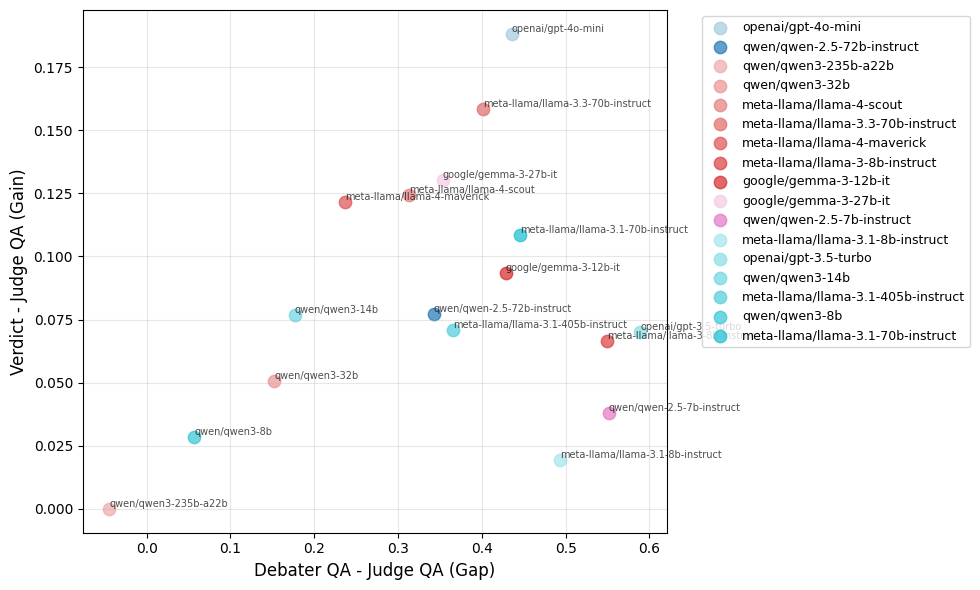

In [421]:
# Plot the verdict_minus_judge_qa as a function of the difference in debater_qa and judge_qa

def plot_gain_scatter(results_df, n_choices, over: Literal["gap", "judge_qa"] = 'gap'):

    fig, ax = plt.subplots(figsize=(10, 6))

    results_df[f'debater_minus_judge'] = results_df[f'debater_qa_acc'] - results_df[f'judge_qa_acc']

    if over == 'gap':
        xfield = f'debater_minus_judge'
    elif over == 'judge_qa':
        xfield = f'judge_qa_acc'

    x = results_df[xfield]
    y = results_df[f'verdict_minus_judge_qa']

    for i, row in results_df.iterrows():
        x_val = row[xfield]
        y_val = row[f'verdict_minus_judge_qa']
        
        ax.scatter(x_val, y_val, color=colors[i], alpha=0.7, s=80, label=row['name'])
        ax.annotate(row['name'], (x_val, y_val), fontsize=7, ha='left', va='bottom', alpha=0.7)

    if xfield == f'judge_qa_acc':
        # Add the f'debater_qa_acc' as a vertical line
        ax.axvline(x=results_df[f'debater_qa_acc'].mean(), color='gray', linestyle='--', linewidth=2, alpha=0.5, label=f'Debater QA Accuracy')
        # Add the change line as a vertical line - it's 1/N_choices
        ax.axvline(x=1/n_choices, color='red', linestyle='--', linewidth=2, alpha=0.5, label='chance')

    # linear fit
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # r_squared = r_value**2
    # x_line = np.linspace(x.min(), x.max(), 100)
    # y_line = slope * x_line + intercept
    # ax.plot(x_line, y_line, 'k--', linewidth=2, alpha=0.5, label=f'Linear fit')
    # stats_text = f'R² = {r_squared:.3f}\np = {p_value:.4f}\nslope = {slope:.3f}'
    # ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
            # verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    field_to_axis_label_map = {
        f'debater_minus_judge': 'Debater QA - Judge QA (Gap)',
        f'judge_qa_acc': 'Judge QA Accuracy'
    }

    ax.set_xlabel(field_to_axis_label_map[xfield], fontsize=12)
    ax.set_ylabel('Verdict - Judge QA (Gain)', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(axis='both', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_gain_scatter(results_df_gpqa_4_choice, n_choices=4)
# plot_gain_scatter(results_df_gpqa_2_choice, n_choices=2)



### Look at GPQA domain breakdown

In [ ]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)

dedupe_columns = dedupe_columns_gpqa_4_choice # doesn't matter which one

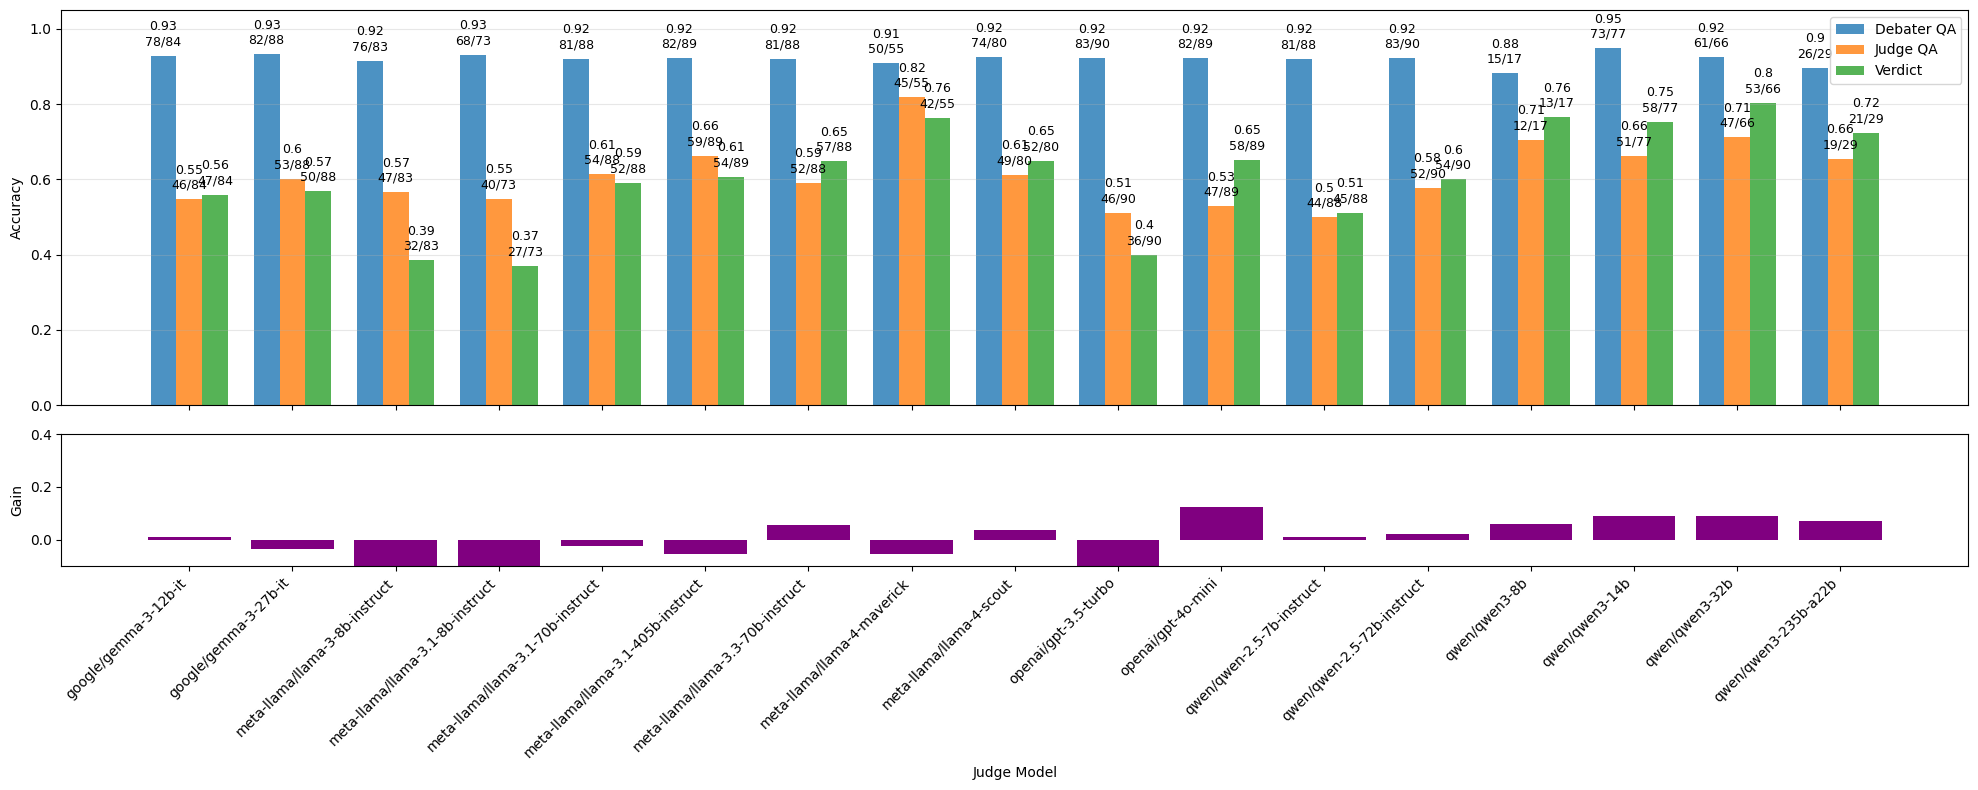

In [545]:
# There's a column called high-level domain in gpqa dataset
# Let's get the data and merged with the results_df


domain = 'Chemistry'
# domain = 'Physics'
# unique_df = unique_df_gpqa_4_choice
unique_df = unique_df_gpqa_2_choice


unique_df = unique_df.merge(dataset_df[['question', 'high_level_domain']], on='question', how='left')
unique_df = unique_df[unique_df['high_level_domain'] == domain]
results_df = results_by_config(unique_df, dedupe_columns)

plot_results_by_name(results_df)


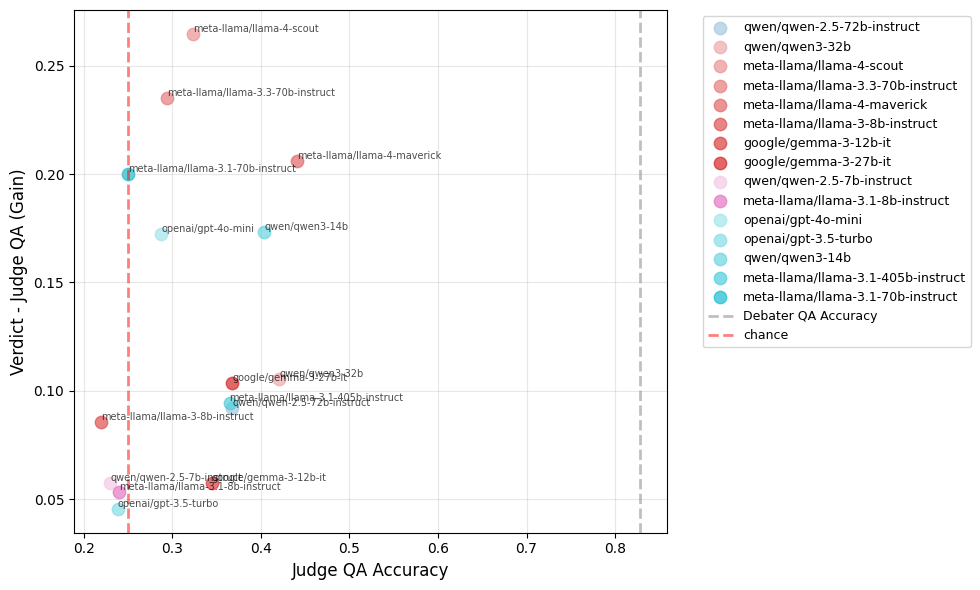

In [452]:
# Add the high-level domain to the records

results_df = results_by_config(unique_df, dedupe_columns)
results_df = results_df[results_df['n_total'] > 45]
plot_gain_scatter(results_df, n_choices=4, over='judge_qa')

/var/folders/9l/xmd1jn1s1gg47vfyv_n8g3xh0000gn/T/ipykernel_66032/2009483954.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['name'], rotation=45, ha='right')
/var/folders/9l/xmd1jn1s1gg47vfyv_n8g3xh0000gn/T/ipykernel_66032/2009483954.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['name'], rotation=45, ha='right')


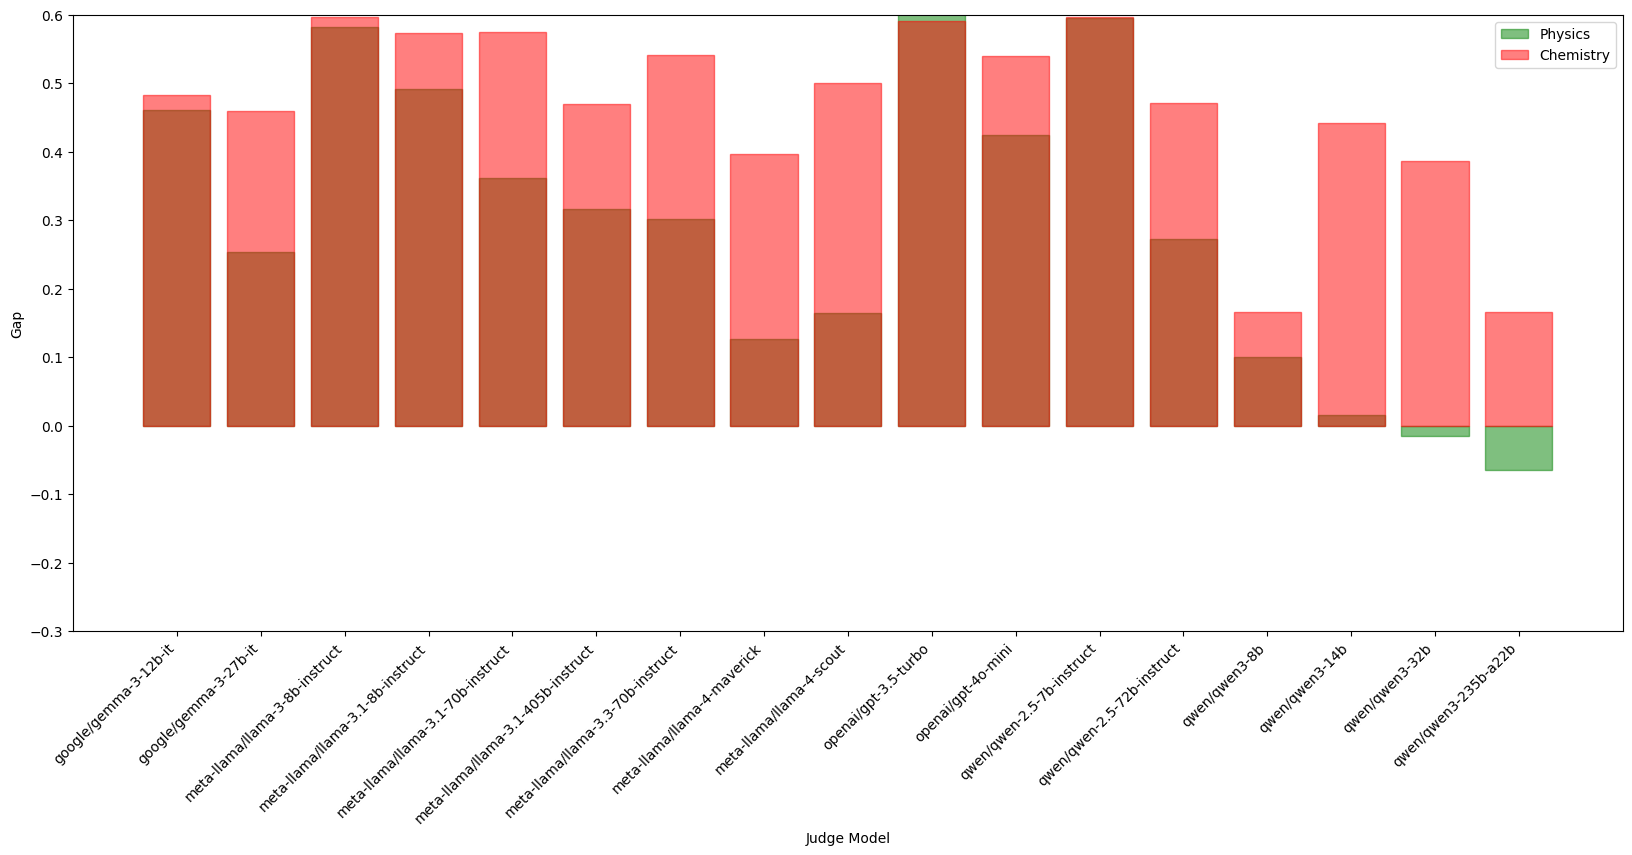

In [533]:
# Compare the physics to chemistry in a bar plot - overlapping with alpha

unique_df = unique_df_gpqa_4_choice
unique_df = unique_df.merge(dataset_df[['question', 'high_level_domain']], on='question', how='left')
unique_df_chemistry = unique_df[unique_df['high_level_domain'] == 'Chemistry']
unique_df_physics = unique_df[unique_df['high_level_domain'] == 'Physics']


results_df_chemistry = results_by_config(unique_df_chemistry, dedupe_columns)
results_df_physics = results_by_config(unique_df_physics, dedupe_columns)

fig, ax = plt.subplots(figsize=(20, 8))
type = 'gap'
bars1 = plot_verdict_difference(results_df_physics, ax=ax, type=type)
bars2 = plot_verdict_difference(results_df_chemistry, ax=ax, type=type)

ax.set_ylim(-.3, .6)

for bar in bars1:
    bar.set_alpha(0.5)
    bar.set_color('green')

for bar in bars2:
    bar.set_alpha(0.5)
    bar.set_color('red')

plt.legend(['Physics', 'Chemistry'])
plt.show()


skipping qwen/qwen3-8b because too few samples: n_0 = 6 and n_1 = 20
skipping qwen/qwen3-235b-a22b because too few samples: n_0 = 6 and n_1 = 31


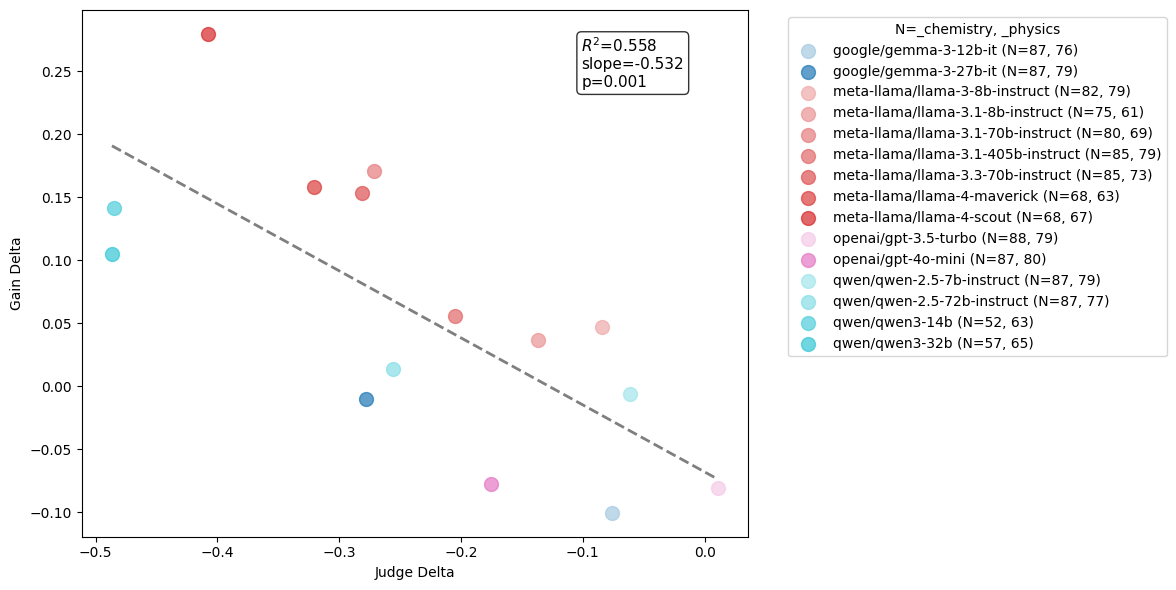

In [544]:
## Look at gap DELTAS relative to gain DELTAS

suffixes = ['_chemistry', '_physics']
merged = results_df_chemistry.merge(results_df_physics, on='name', suffixes=suffixes)

# suffixes = ['_4choice', '_2choice']
# merged = results_df_gpqa_4_choice.merge(results_df_gpqa_2_choice, on='name', suffixes=suffixes)

# xfield = 'gap_delta'
xfield = 'judge_delta'

yfield = 'gain_delta'
# yfield = 'gap_delta'


merged['gap_delta'] = merged[f'debater_minus_judge_qa{suffixes[0]}'] - merged[f'debater_minus_judge_qa{suffixes[1]}']
merged['gain_delta'] = merged[f'verdict_minus_judge_qa{suffixes[0]}'] - merged[f'verdict_minus_judge_qa{suffixes[1]}']
merged['judge_delta'] = merged[f'judge_qa_acc{suffixes[0]}'] - merged[f'judge_qa_acc{suffixes[1]}']

fig, ax = plt.subplots(figsize=(12, 6))

names, color_map = sort_and_color_by_model_family(merged['name'])
for name in names:
    row = merged[merged['name'] == name].iloc[0]
    n_0 = int(row[f'n_total{suffixes[0]}'])
    n_1 = int(row[f'n_total{suffixes[1]}'])
    if n_0 < 50 or n_1 < 50:
        # print('hi')
        print(f'skipping {name} because too few samples: n_0 = {n_0} and n_1 = {n_1}')
        continue
    ax.scatter(row[xfield], row[yfield], 
               color=color_map[name], 
               label=f"{name} (N={n_0}, {n_1})",
               alpha=0.7,
               s=100)

slope, intercept, r, p, se = stats.linregress(merged[xfield], merged[yfield])
x_line = np.linspace(merged[xfield].min(), merged[xfield].max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'k--', alpha=0.5, linewidth=2)

# ax.text(0.05, 0.95, f'$R^2$={r**2:.3f}\nslope={slope:.3f}\np={p:.3f}', 
#         transform=ax.transAxes, fontsize=11, verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.text(0.75, 0.95, f'$R^2$={r**2:.3f}\nslope={slope:.3f}\np={p:.3f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fieldname_to_label_map = {
    'gap_delta': 'Gap Delta',
    'judge_delta': 'Judge Delta',
    'gain_delta': 'Gain Delta'
}

ax.set_xlabel(fieldname_to_label_map[xfield])
ax.set_ylabel(fieldname_to_label_map[yfield])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=f'N={suffixes[0]}, {suffixes[1]}')

# ax.set_xlim(-.5, .5)
# ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()






In [494]:
merged[['name', 'judge_delta', 'gain_delta']]

,name,judge_delta,gain_delta
0,openai/gpt-4o-mini,-0.175067,0.021505
1,qwen/qwen-2.5-72b-instruct,-0.134543,-0.010735
2,qwen/qwen3-235b-a22b,0.141126,-0.051948
3,qwen/qwen3-32b,-0.128967,-0.012567
4,meta-llama/llama-4-scout,-0.174267,0.101326
5,meta-llama/llama-3.3-70b-instruct,-0.270075,0.141799
6,meta-llama/llama-4-maverick,-0.216109,0.121622
7,meta-llama/llama-3-8b-instruct,-0.300000,0.150000
8,google/gemma-3-12b-it,-0.187473,0.093407
9,google/gemma-3-27b-it,-0.149613,0.114728


### Breakdown the results by category for MMLU-Pro

In [558]:
# From TIGER-Lab/MMLU-Pro, there's a column called "category"
# Add this column to the merged_df

# verdict_run_id = 'ntxteqy'
# verdict_run_id = '07e1puy'
# verdict_run_id = '9amuk8w'
verdict_run_id = '4nay3cp'

merged_df = load_debate_and_verdict_and_qa(verdict_run_id)
mmlu_dataset = load_dataset('TIGER-Lab/MMLU-Pro')['test']

category_map = {}
for idx in range(len(mmlu_dataset)):
    category_map[idx] = mmlu_dataset[idx].get('category', None)
merged_df['category'] = merged_df['question_idx'].map(category_map)

print(merged_df['category'].value_counts())



loaded verdict: 4nay3cp: starting records: 1280, dropped 73 without judge QA, dropped 15 without debater QA, final records: 1192
category
other               124
law                 121
economics           116
physics             108
health              102
math                 98
psychology           96
chemistry            92
philosophy           70
biology              66
engineering          61
business             54
history              42
computer science     42
Name: count, dtype: int64


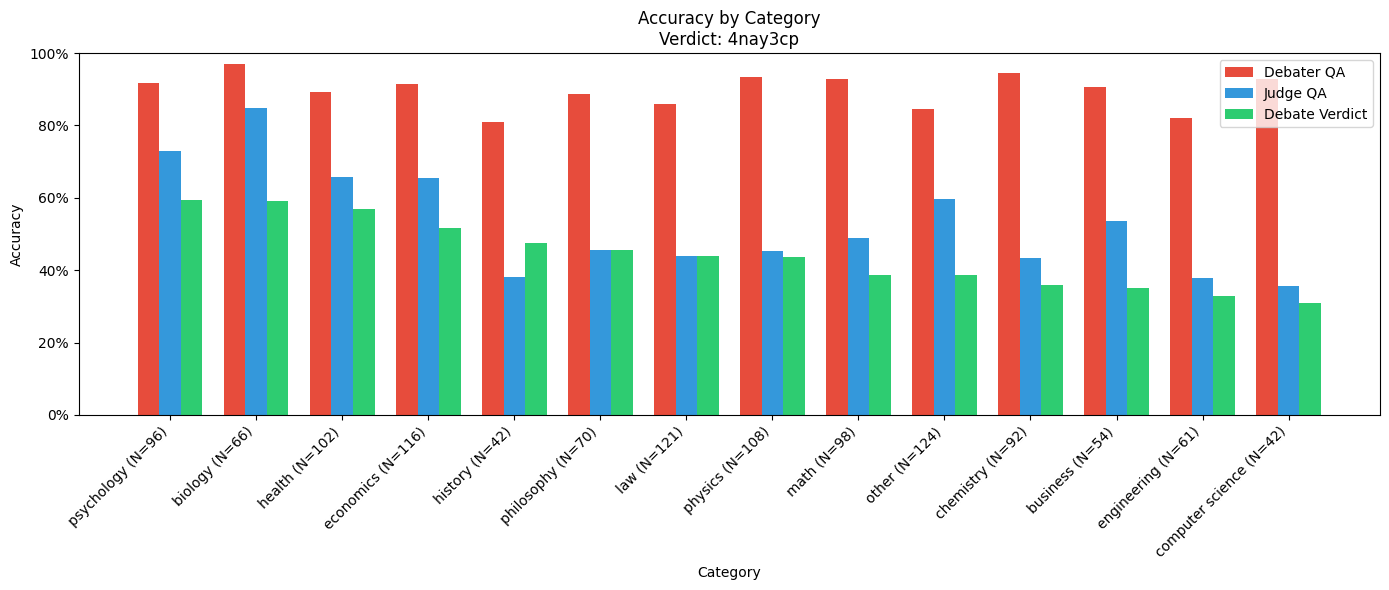


Category Results:
        category is_correct_debater_qa is_correct_judge_qa  is_correct_verdict  count
      psychology              0.916667            0.729167            0.593750     96
         biology              0.969697            0.848485            0.590909     66
          health              0.892157            0.656863            0.568627    102
       economics              0.913793            0.655172            0.517241    116
         history              0.809524            0.380952            0.476190     42
      philosophy              0.885714            0.457143            0.457143     70
             law              0.859504            0.438017            0.438017    121
         physics              0.935185            0.453704            0.435185    108
            math              0.928571            0.489796            0.387755     98
           other              0.846774            0.596774            0.387097    124
       chemistry              0.945

In [559]:
category_results = merged_df.groupby('category').agg({
    'is_correct_debater_qa': 'mean',
    'is_correct_judge_qa': 'mean',
    'is_correct_verdict': ['mean', 'count']
}).reset_index()

category_results.columns = ['category', 'is_correct_debater_qa', 'is_correct_judge_qa', 'is_correct_verdict', 'count']
category_results = category_results.sort_values('is_correct_verdict', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))

categories = category_results['category']
counts = category_results['count']
x = np.arange(len(categories))
width = 0.25

bars1 = ax.bar(x - width, category_results['is_correct_debater_qa'], width, label='Debater QA', color='#e74c3c')                                                                                                        
bars2 = ax.bar(x, category_results['is_correct_judge_qa'], width, label='Judge QA', color='#3498db')
bars3 = ax.bar(x + width, category_results['is_correct_verdict'], width, label='Debate Verdict', color='#2ecc71')                                                                                                       

ax.set_xlabel('Category')
ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy by Category\nVerdict: {verdict_run_id}')
ax.set_xticks(x)
category_labels = [f'{cat} (N={cnt})' for cat, cnt in zip(categories, counts)]
ax.set_xticklabels(category_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.show()

print(f"\nCategory Results:")
print(category_results.to_string(index=False))

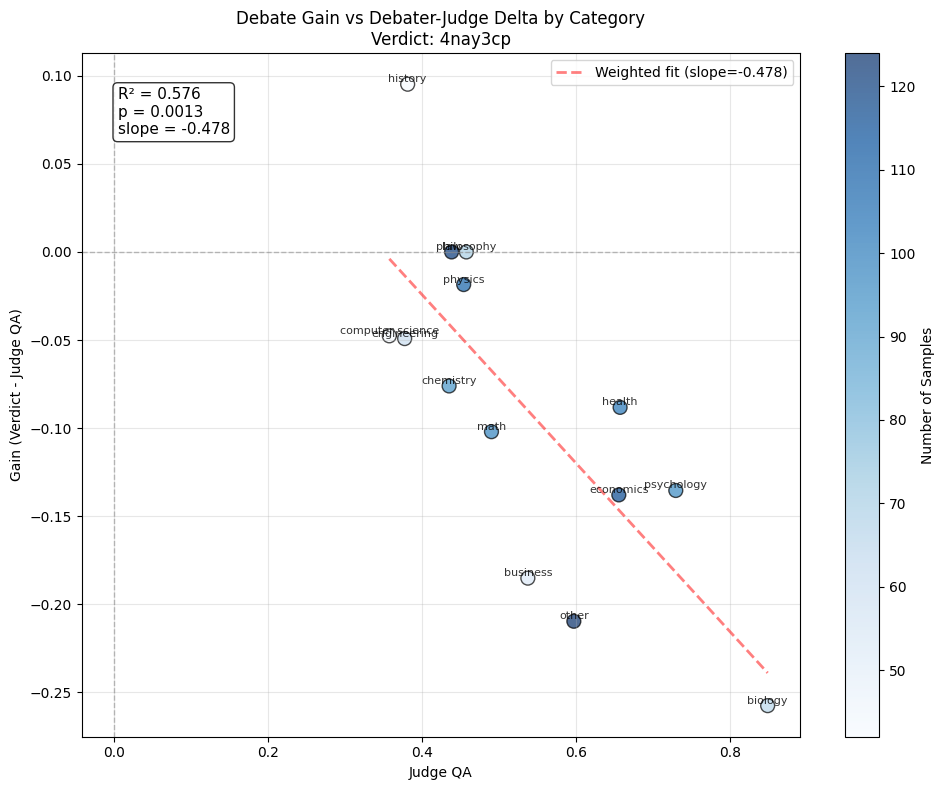


Scatter Plot Data:
        category    delta      gain  count
      psychology 0.187500 -0.135417     96
         biology 0.121212 -0.257576     66
          health 0.235294 -0.088235    102
       economics 0.258621 -0.137931    116
         history 0.428571  0.095238     42
      philosophy 0.428571  0.000000     70
             law 0.421488  0.000000    121
         physics 0.481481 -0.018519    108
            math 0.438776 -0.102041     98
           other 0.250000 -0.209677    124
       chemistry 0.510870 -0.076087     92
        business 0.370370 -0.185185     54
     engineering 0.442623 -0.049180     61
computer science 0.571429 -0.047619     42


In [ ]:
category_results['judge_acc'] = category_results['is_correct_judge_qa'].astype(float)
category_results['gap'] = category_results['is_correct_debater_qa'].astype(float) - category_results['is_correct_judge_qa'].astype(float)
category_results['gain'] = category_results['is_correct_verdict'].astype(float) - category_results['is_correct_judge_qa'].astype(float)

from scipy import stats
from sklearn.linear_model import LinearRegression

# xfield = 'gap'
xfield = 'judge_acc'
yfield = 'gain'

x = category_results[xfield].values.astype(float)
y = category_results[yfield].values.astype(float)
weights = category_results['count'].values.astype(float)

model = LinearRegression()
model.fit(x.reshape(-1, 1), y, sample_weight=weights)
slope = model.coef_[0]
intercept = model.intercept_

y_pred = model.predict(x.reshape(-1, 1))
ss_res = np.sum(weights * (y - y_pred)**2)
ss_tot = np.sum(weights * (y - np.average(y, weights=weights))**2)
r_squared = 1 - (ss_res / ss_tot)

pearson_r, p_value = stats.pearsonr(x, y)

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(category_results[xfield], category_results[yfield], 
                     c=category_results['count'], s=100, cmap='Blues', alpha=0.7, edgecolors='black')

x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.5, label=f'Weighted fit (slope={slope:.3f})')

for i, row in category_results.iterrows():
    ax.annotate(row['category'], (row[xfield], row[yfield]), 
                fontsize=8, ha='center', va='bottom', alpha=0.8)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

stats_text = f'R² = {r_squared:.3f}\np = {p_value:.4f}\nslope = {slope:.3f}'
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fieldname_to_label_map = {
    'gap': 'Gap (Debater QA - Judge QA)',
    'gain': 'Gain (Verdict - Judge QA)',
    'judge_acc': 'Judge QA'
}


ax.set_xlabel(fieldname_to_label_map[xfield])
ax.set_ylabel(fieldname_to_label_map[yfield])
ax.grid(True, alpha=0.3)
ax.legend()

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Samples')

plt.tight_layout()
plt.show()

print("\nScatter Plot Data:")
print(category_results[['category', 'delta', 'gain', 'count']].to_string(index=False))


### Analysis across verdict runs

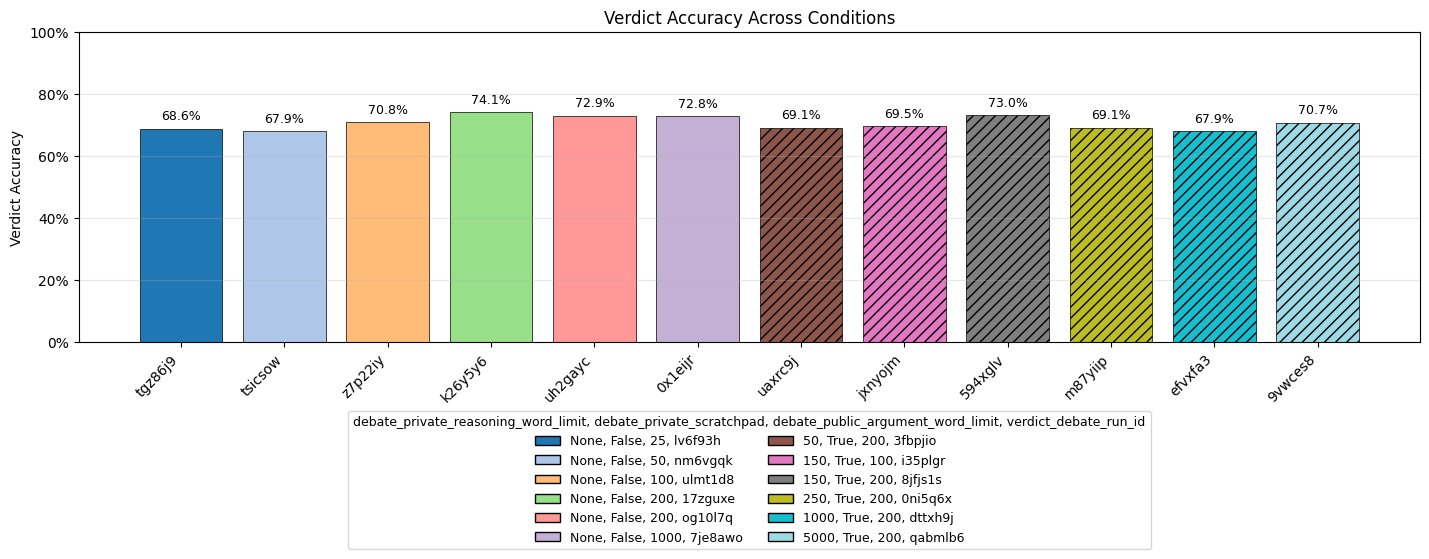

Differing parameters: ['debate_private_reasoning_word_limit', 'debate_private_scratchpad', 'debate_public_argument_word_limit', 'verdict_debate_run_id']

Accuracies:
  tgz86j9: 68.65%
  tsicsow: 67.86%
  z7p22iy: 70.83%
  k26y5y6: 74.09%
  uh2gayc: 72.92%
  0x1eijr: 72.83%
  uaxrc9j: 69.07%
  jxnyojm: 69.54%
  594xglv: 73.02%
  m87yiip: 69.07%
  efvxfa3: 67.88%
  9vwces8: 70.68%


In [20]:
def get_combined_config(verdict_run_id):
    df = load_debate_and_verdict(verdict_run_id)
    return {col.replace('config_', ''): df.iloc[0][col] for col in df.columns if col.startswith('config_')}

verdicts_run_ids = ['uh2gayc', 'z7p22iy', 'jxnyojm', '594xglv', 'm87yiip', '0x1eijr', 'k26y5y6', 'efvxfa3', '9vwces8', 'uaxrc9j', 'tgz86j9', 'tsicsow']

all_configs = {}
for verdict_run_id in verdicts_run_ids:
    config = get_combined_config(verdict_run_id)
    if config:
        all_configs[verdict_run_id] = config

metadata_keys = {'run_id', 'record_id', 'datetime', 'debate_run_id', 'verdict_run_id'}
all_param_keys = set()
for config in all_configs.values():
    all_param_keys.update(k for k in config.keys() if k not in metadata_keys)

differing_params = []
for param_key in sorted(all_param_keys):
    values = [all_configs.get(vid, {}).get(param_key) for vid in verdicts_run_ids if vid in all_configs]
    unique_values = set(v for v in values if v is not None)
    if len(unique_values) > 1:
        differing_params.append(param_key)

accuracies = []
value_lists = []
run_ids_included = []

for verdict_run_id in verdicts_run_ids:
    if verdict_run_id not in all_configs:
        continue
    
    df = load_verdict(verdict_run_id)
    accuracy = df['is_correct_verdict'].mean()
    accuracies.append(accuracy)
    run_ids_included.append(verdict_run_id)
    
    config = all_configs[verdict_run_id]
    values = []
    for param in differing_params:
        value = config.get(param)
        if value is not None:
            values.append(str(value))
        else:
            values.append("None")
    value_lists.append(", ".join(values))

# Sort by parameter values
def smart_sort_key(item):
    _, _, value_str = item
    parts = value_str.split(", ")
    result = []
    for part in parts:
        if part == "None":
            result.append((0, None))
        elif part == "False":
            result.append((1, False))
        elif part == "True":
            result.append((2, True))
        else:
            try:
                result.append((3, int(part)))
            except ValueError:
                result.append((4, part))
    return result

sorted_data = sorted(zip(accuracies, run_ids_included, value_lists), key=smart_sort_key)
accuracies, run_ids_included, value_lists = zip(*sorted_data)

colors = plt.cm.tab20(np.linspace(0, 1, len(accuracies)))

fig, ax = plt.subplots(figsize=(max(10, len(accuracies) * 1.2), 6))

# Create bars with hatching for scratchpad runs
bars = []
for idx in range(len(accuracies)):
    config = all_configs[run_ids_included[idx]]
    has_scratchpad = config.get("debate_private_scratchpad", False)
    hatch = "///" if has_scratchpad else None
    bar = ax.bar(idx, accuracies[idx], color=colors[idx], hatch=hatch, edgecolor="black", linewidth=0.5)
    bars.append(bar)
ax.set_xticks(range(len(accuracies)))
ax.set_xticklabels(run_ids_included, rotation=45, ha='right')
ax.set_ylabel('Verdict Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_title('Verdict Accuracy Across Conditions')
ax.grid(True, alpha=0.3, axis='y')

for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.02, f'{acc:.1%}', ha='center', va='bottom', fontsize=9)

param_header = ", ".join(differing_params)
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='black', label=value_lists[i]) 
                   for i in range(len(value_lists))]
legend = ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), 
                   ncol=2, fontsize=9, title=param_header, title_fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

print(f"Differing parameters: {differing_params}")
print(f"\nAccuracies:")
for vid, acc in zip(run_ids_included, accuracies):
    print(f"  {vid}: {acc:.2%}")


### Analyze token usage in the debate run

In [12]:
run_id = 'dttxh9j'

debate_df = load_debate(run_id)

record_ids = []
completion_tokens_used_per_debate = []
reasoning_tokens_used_per_debate = []
for i, row in debate_df.iterrows():
    if row['success'] == False:
        continue
    record_ids.append(row['record_id'])
    debate_history = row['debate_history']
    completion_tokens_used_this_debate, reasoning_tokens_used_this_debate = 0, 0
    for turn in debate_history:
        completion_tokens_used_this_debate += turn['token_usage']['completion_tokens']
        if 'completion_tokens_details' in turn['token_usage'] and turn['token_usage']['completion_tokens_details'] is not None:
            reasoning_tokens_used_this_debate += turn['token_usage']['completion_tokens_details']['reasoning_tokens']
        else:
            reasoning_tokens_used_this_debate += 0
    completion_tokens_used_per_debate.append(completion_tokens_used_this_debate)
    reasoning_tokens_used_per_debate.append(reasoning_tokens_used_this_debate)

print(record_ids)
print(f"completion_tokens_used_per_debate: {completion_tokens_used_per_debate}")
print(f"reasoning_tokens_used_per_debate: {reasoning_tokens_used_per_debate}")


['kzrous5', 'hk8ubqd', '1qcavop', 'b4wassv', 'x3lzxbz', 'jh5jbyi', 'l1s826e', 'vxw819y', 'ft9z8yh', 'qstcwfj', 'j62qcbg', 'phcxgez', 'va1sr4j', '5d9hjkx', 'p4yqd71', 'r63u681', '655fxkg', 'stu7xez', '2dfhjyj', 'kyrmnkc', 'c7sckgd', 'iudop67', 'ecgh0pm', '8j7dz44', 'b1rimbx', 'cr0cdmf', 'a9bsn0e', 'c106unw', '3o3oiz2', 'x6gy4lo', 'pd11e05', 'cjzpl8j', '9pix5ix', '65943js', 'qn8ii0f', 'nqfni3t', 'zbcgy6y', 'y5658ma', 'xdybjn8', '6qwbjic', '7ap29ri', 'netnuxw', 'k8oab27', 'tkq4jwm', 'cb69ar8', 'xijlfq4', 'ynxmamb', 'f5dz059', 'mxtsuep', '3rl3ehv', '0i9k3x0', 'img9dz9', 'n159vel', 'ol30dgs', 'vt4ufjj', 'vy0uxu4', 'axegwzl', 'lp5odyr', 'rcucqoa', '2dmo93w', 'ran59bn', 'v4eww3t', 'cuhgta4', 'usa1ce0', 'w9a4xcq', 'srmo6fm', 's6b9i6d', 'c2j4go8', 'z34r23h', 'qifw16n', 'hm1rbnf', '0156a9s', 'k3414go', 'oofglb7', '9z1omif', 'ure0jqh', 'ot76ght', 'iilcjvg', '65effsm', 'qr8rx44', '59ctvmi', 'axqjuyg', '3qp6fws', 'bfqhed6', 'ywfgkuk', 'xxthyfy', 'fumf7yx', '4stbyiy', '5gc75gp', '32tfp35', '6otyiog'